In [2]:
import torch
from tqdm.notebook import tqdm
import numpy as np
from transformer.reimei import ReiMei, ReiMeiParameters
import matplotlib.pyplot as plt
from config import AE_CHANNELS, DIT_S as DIT, MODELS_DIR_BASE, SIGLIP_HF_NAME, BERT_HF_NAME, SIGLIP_EMBED_DIM, BERT_EMBED_DIM
from torch.amp import autocast
from transformers import SiglipTokenizer, SiglipTextModel, AutoTokenizer, ModernBertModel
from diffusers import AutoencoderDC

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "d:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
    ^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'triton'


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
# base_dim = 1024
# base_heads = 32

input_dim = AE_CHANNELS
num_layers = 24
embed_dim = 1152
num_heads = embed_dim // 32
mlp_dim = embed_dim
num_experts = 64
active_experts = 2.0
shared_experts = 1
token_mixer_layers = 2
image_text_expert_ratio = 16
dropout = 0.1

# m_d = float(embed_dim) / float(base_dim)

# assert (embed_dim // num_heads) == (base_dim // base_heads)

params = ReiMeiParameters(
    channels=input_dim,
    embed_dim=embed_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    mlp_dim=mlp_dim,
    siglip_dim=SIGLIP_EMBED_DIM,
    bert_dim=BERT_EMBED_DIM,
    num_experts=num_experts,
    active_experts=active_experts,
    shared_experts=shared_experts,
    dropout=dropout,
    token_mixer_layers=token_mixer_layers,
    image_text_expert_ratio=image_text_expert_ratio,
    # m_d=m_d,
)
DTYPE = torch.bfloat16

In [5]:
model = ReiMei(params)
# model.load_state_dict(torch.load("models/reimei_model_and_optimizer_epoch_40_f32.pt")['ema_model_state_dict'])

In [6]:
# Print the number of parameters in the model
print("Number of parameters in the model: ", sum(p.numel() for p in model.parameters()))


Number of parameters in the model:  6495189560


In [4]:
siglip_model = SiglipTextModel.from_pretrained(SIGLIP_HF_NAME, cache_dir=f"{MODELS_DIR_BASE}/siglip").to(device)
siglip_tokenizer = SiglipTokenizer.from_pretrained(SIGLIP_HF_NAME, cache_dir=f"{MODELS_DIR_BASE}/siglip")

In [4]:
bert_model = ModernBertModel.from_pretrained(BERT_HF_NAME, cache_dir=f"{MODELS_DIR_BASE}/modernbert").to(device)
bert_tokenizer = AutoTokenizer.from_pretrained(BERT_HF_NAME, cache_dir=f"{MODELS_DIR_BASE}/modernbert")

In [11]:
class TextEmbedder:
    def __init__(self, model, tokenizer, device):
        """Initialize with the model, tokenizer, and device."""
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    @torch.inference_mode()
    @torch.autocast(device_type="cuda", dtype=torch.bfloat16)
    def generate(self, captions):
        """Generate embeddings for a list of captions."""
        texts = self.tokenizer(captions).to(self.device)
        text_embeddings = self.model(texts)
        return text_embeddings

In [12]:
siglip = TextEmbedder(siglip_model, siglip_tokenizer, device)


In [13]:
x = siglip.generate(["A cat sitting on a table", "A cat and a dog playing together in the grass"])
x.shape

AttributeError: 

In [5]:
padded_len = 64


In [6]:
prompts = [
    "A group of people in traditional Indian attire gather around a table laden with food, blending traditional and modern elements in a casual and relaxed atmosphere." 
] * 1

In [7]:
siglip_inputs = []
unpadded_lens = []
for prompt in prompts:
    input = siglip_tokenizer.encode(prompt, return_tensors="pt", padding=True).to("cuda").squeeze()
    unpadded_lens.append(input.shape[-1])
    if input.shape[0] < padded_len:
        padding = torch.zeros(padded_len - input.shape[0], dtype=input.dtype, device=input.device)
        input = torch.cat([input, padding])
    else:
        input = input[:padded_len]
    siglip_inputs.append(input)

torch.Size([32])


In [10]:
bert_inputs = []
unpadded_lens = []
for prompt in prompts:
    input = bert_tokenizer.encode("[CLS]"+prompt, return_tensors="pt", padding=True).to("cuda").squeeze()
    unpadded_lens.append(input.shape[-1])
    if input.shape[0] < 65:
        padding = torch.ones(65 - input.shape[0], dtype=input.dtype, device=input.device)
        input = torch.cat([input, padding])
    else:
        input = input[:65]
    bert_inputs.append(input)

torch.Size([33])


In [11]:
siglip_inputs = torch.stack(siglip_inputs)

In [12]:
bert_inputs = torch.stack(bert_inputs)

In [32]:
siglip_outputs = siglip_model(siglip_inputs, output_hidden_states=True)
siglip_embeddings = siglip_outputs.hidden_states[-1]
siglip_vec = siglip_outputs.pooler_output

In [14]:
bert_outputs = bert_model(bert_inputs, output_hidden_states=True).hidden_states[-1] # (bs, 65, 768). The 65 is CLS + 64 tokens. So we need to seperate the CLS token from the rest.
bert_vec = bert_outputs[:, 0, :] # (bs, 1024)
bert_embeddings = bert_outputs[:, 1:, :] # (bs, 64, 1024)

In [20]:
bert_embeddings_mean = (bert_embeddings*0.01).mean()
bert_embeddings_std = (bert_embeddings*0.01).std()
bert_vec_mean = bert_vec.mean()
bert_vec_std = bert_vec.std()

siglip_embeddings_mean = siglip_embeddings.mean()
siglip_embeddings_std = siglip_embeddings.std()
siglip_vec_mean = siglip_vec.mean()
siglip_vec_std = siglip_vec.std()

print("BERT Embeddings Mean:", bert_embeddings_mean)
print("BERT Embeddings Std Dev:", bert_embeddings_std)
print("BERT Vec Mean:", bert_vec_mean)
print("BERT Vec Std Dev:", bert_vec_std)
print("Siglip Embeddings Mean:", siglip_embeddings_mean)
print("Siglip Embeddings Std Dev:", siglip_embeddings_std)
print("Siglip Vec Mean:", siglip_vec_mean)
print("Siglip Vec Std Dev:", siglip_vec_std)


BERT Embeddings Mean: tensor(-0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
BERT Embeddings Std Dev: tensor(1.3353, device='cuda:0', grad_fn=<StdBackward0>)
BERT Vec Mean: tensor(0.2094, device='cuda:0', grad_fn=<MeanBackward0>)
BERT Vec Std Dev: tensor(14.1407, device='cuda:0', grad_fn=<StdBackward0>)
Siglip Embeddings Mean: tensor(0.7216, device='cuda:0', grad_fn=<MeanBackward0>)
Siglip Embeddings Std Dev: tensor(1.1179, device='cuda:0', grad_fn=<StdBackward0>)
Siglip Vec Mean: tensor(-0.0570, device='cuda:0', grad_fn=<MeanBackward0>)
Siglip Vec Std Dev: tensor(1.0032, device='cuda:0', grad_fn=<StdBackward0>)


In [35]:
from torch.nn.modules.normalization import RMSNorm

rmsnorm = RMSNorm(bert_vec.shape[-1]).to(device)
bert_vec = rmsnorm(bert_vec)

bert_vec_mean = (bert_vec).mean()
bert_vec_std = (bert_vec).std()

print("BERT Embeddings Mean:", bert_vec_mean)
print("BERT Embeddings Std Dev:", bert_vec_std)

BERT Embeddings Mean: tensor(0.0148, device='cuda:0', grad_fn=<MeanBackward0>)
BERT Embeddings Std Dev: tensor(1.0004, device='cuda:0', grad_fn=<StdBackward0>)


In [15]:
bert_embeddings.shape

torch.Size([1, 64, 1024])

In [16]:
siglip_embeddings.shape, 

(torch.Size([1, 64, 1152]),)

In [19]:
del siglip_model, bert_model, siglip_tokenizer, bert_tokenizer

In [20]:
noise = torch.randn(1, 32, 32, 32).to(device).to(torch.bfloat16)

In [21]:
model = model.eval().to(device, dtype=torch.bfloat16)
with autocast("cuda", dtype=torch.bfloat16):
    pred = model.sample(noise, siglip_embeddings, siglip_vec, bert_embeddings, bert_vec, sample_steps=50, cfg=7.0)
    del model

In [22]:
vae = AutoencoderDC.from_pretrained("mit-han-lab/dc-ae-f32c32-in-1.0-diffusers", torch_dtype=DTYPE, cache_dir=f"{MODELS_DIR_BASE}/dc_ae", revision="main").to(device, ).eval()
# print param count
print(sum(p.numel() for p in vae.parameters()))

323356460


In [23]:
# model = model.eval()
with autocast("cuda", dtype=torch.bfloat16):
    # pred = model.sample(noise, siglip_embeddings, siglip_vec, bert_embeddings, bert_vec, sample_steps=50, cfg=7.0)

    pred = vae.decode(pred).sample
    # Change range of pred from x to y to -1 to 1
    min_val = pred.min()
    max_val = pred.max()

    pred = (pred - min_val) / (max_val - min_val)
    pred = 2 * pred - 1

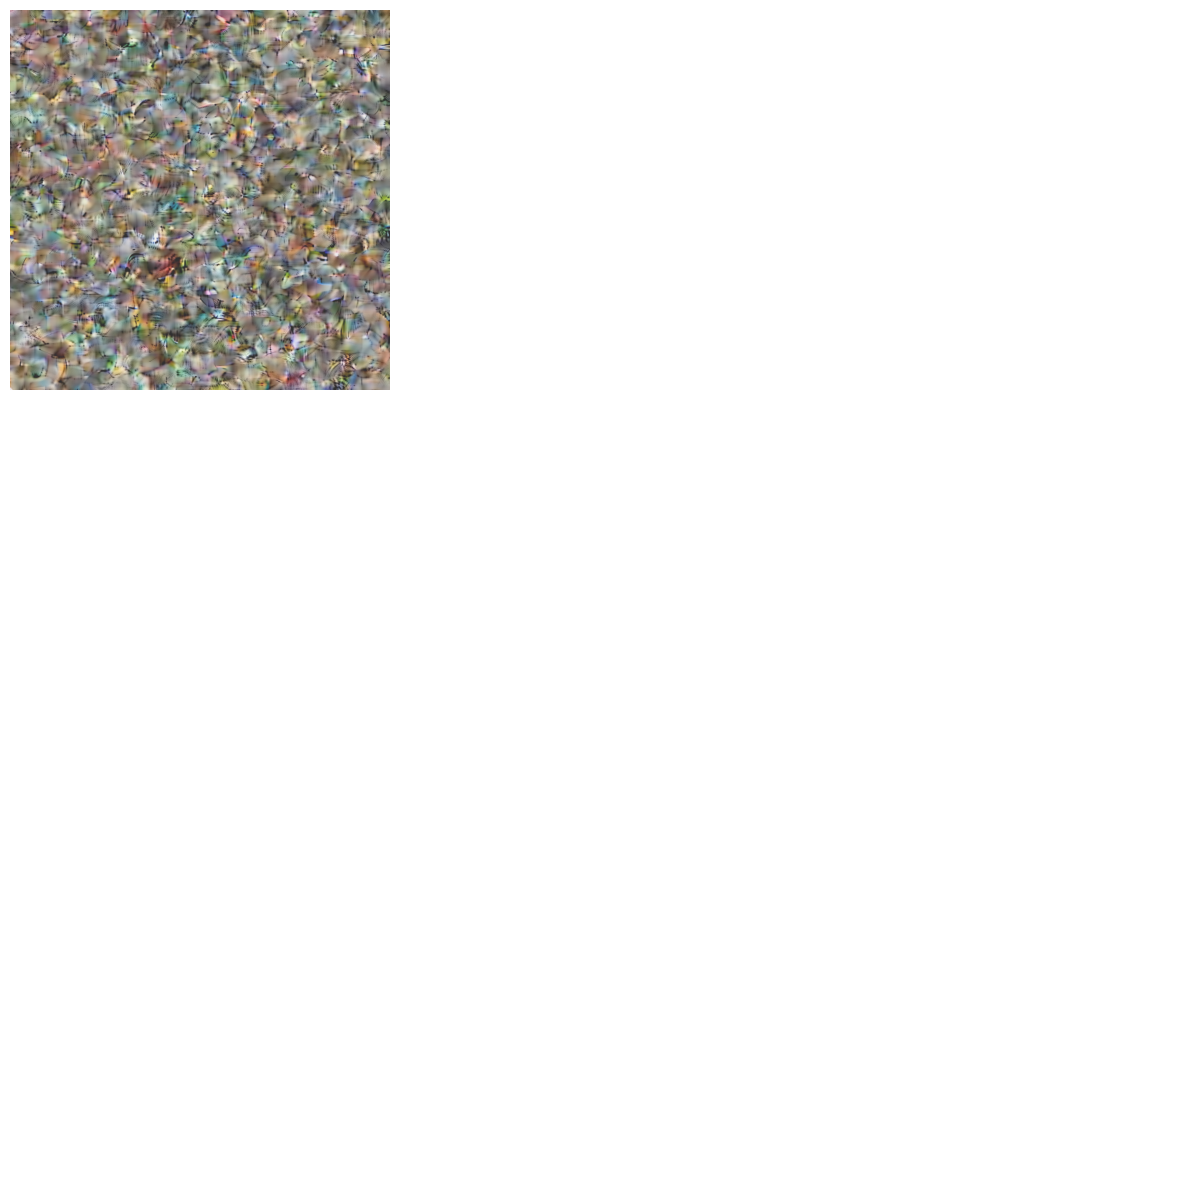

In [24]:
with torch.inference_mode():
    pred_cpu = pred.cpu().to(torch.float32)
    pred_np = pred_cpu.permute(0, 2, 3, 1).numpy()
    pred_np = (pred_np + 1) / 2
    pred_np = (pred_np * 255).astype(np.uint8)  # Convert to uint8

    # Create figure for predictions
    fig_pred, axes_pred = plt.subplots(3, 3, figsize=(12, 12))  # 3 rows, 3 columns

    # Plot predictions
    for i, ax in enumerate(axes_pred.flatten()):
        if i < pred_np.shape[0]:
            ax.imshow(pred_np[i])
            # ax.set_title(prompts[i])  # Add this line to set the title
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()